# LGBM - atmaCup16 with RECRUIT

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, KFold

In [2]:
class CFG:
    seed = 510
    num_folds = 5
    
    # モデルのパラメータ
    n_estimators = 10000
    learning_rate = .1

In [3]:
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

import numpy as np

%matplotlib inline

# @ref: https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
seed_everything(CFG.seed)

## Load data

In [4]:
train_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_log.csv")
train_labels_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_label.csv")
test_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/test_log.csv")
yados_df = pd.read_csv("/kaggle/input/atmacup16-recruit/yado.csv")

In [5]:
# 欠損値の補完
yados_df = yados_df.fillna(
    {
        "wireless_lan_flg": 0,
        "onsen_flg": 0,
        "kd_stn_5min": 0,
        "kd_bch_5min": 0,
        "kd_slp_5min": 0,
        "kd_conv_walk_5min": 0,
    }
).astype(
    {
        "yad_no": np.int32,
        "yad_type": np.int8,
#         "total_room_count": np.int32, # TODO: NaNの扱い（中央値とする？）
        "wireless_lan_flg": np.int8,
        "onsen_flg": np.int8,
        "kd_stn_5min": np.int8,
        "kd_slp_5min": np.int8,
        "kd_bch_5min": np.int8,
        "kd_conv_walk_5min": np.int8,        
    }
)

In [6]:
# ログをまとめたdf
whole_logs_df = pd.concat([train_logs_df, test_logs_df], axis=0, ignore_index=True)

## Candidate

#### 人気アイテム(エリアは絞る)

In [7]:
# 宿の出現回数
yad_count = train_logs_df.groupby("yad_no").size().rename("yad_count").reset_index()

_df = pd.merge(yad_count, yados_df, on="yad_no", how="left")

_df = _df.sort_values("yad_count", ascending=False)

# 県内での出現回数top_nを取得
ken_top30 = _df.groupby("ken_cd").head(30)

ken_top30.groupby("ken_cd").size()

ken_cd
013592a15b9a689232792f11da797ac7    30
06a6febd7478c1aa664ed5ac87f2d560    30
072c85e1653e10c9c7dd065ad007125a    30
0745a2107686fcb724892ce52f19d02e    30
0a66f6ab9c0507059da6f22a0e1f1690    30
107c7305a74c8dcc4f143de208bf7ec2    30
21a8fca457386861964bea1ffa848fdd    30
223938a74a609968141867c244086206    30
2b99151dba9558109a35c75a3c05c38b    30
31a0f630d36db568ab23c9c1cd80d1c1    30
3831f43bb997a3028669c251c2c2f552    30
39c3eb151762dd35cf50e8bde404ae74    30
3acaaea4dab8892b5c9832f1b32f9448    30
3b09a7ce9934c00fd266f9cf246308d1    30
470fa9ac04f80c7e13db398668e124bf    30
517061b8165aa6370d9025951a64aa52    30
543ea7c443fdfd779bbd557f2ad99d80    30
558ac1909f0318b82c621ab250329d6d    30
572d60f0f5212aacda515ebf81fb0a3a    30
6692a692f80687411022c08e4f5a7a00    30
66c4d01ad8e30155582cf80b1d655986    30
689cf8289e7ea0b2eef1b017dcdfe8de    30
6920865be128aa14814810654738b159    30
6d279eafce12f1a118fe7cbaa74f105a    30
75617bb07a2785a948ab1958909211f1    30
7bc5fba93082f02f1c

In [8]:
ken_top30[ken_top30["ken_cd"] == "013592a15b9a689232792f11da797ac7"]

,yad_no,yad_count,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
5975,6164,214,0,64.0,1,1,0,0,0,0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
7407,7649,187,0,173.0,1,1,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
1185,1227,183,0,233.0,1,1,1,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,989ce3ae2fc5f1649bd10e05917a27f8,ed85e7b17b271de96e7e22ab2bff4aa7
5171,5331,142,0,119.0,1,0,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,989ce3ae2fc5f1649bd10e05917a27f8,ed85e7b17b271de96e7e22ab2bff4aa7
10721,11077,128,0,183.0,1,1,0,0,0,0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81
5882,6069,127,0,120.0,1,1,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
4644,4785,125,0,31.0,1,1,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81
8366,8646,121,0,NaN,1,1,0,0,0,0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
7917,8173,118,0,47.0,1,1,0,0,0,0,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,3db7301525fb3bc026edf7846eae7827,b8a4aaa1954614dee2ed2422b6b670bd
2452,2529,116,0,72.0,1,1,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,013592a15b9a689232792f11da797ac7,6d7e40c7eae769872f8e1388097f2a62,73d0b2ebb84e0ae35e1ec6c0d64dff81


In [9]:
# global変数として、yados_df, ken_top30がある
# yados_df: classのインスタンス変数とする
# ken_top30: コンストラクタ内で作るようにしたい
def create_session_yad_df(input_df: pd.DataFrame):
    """(session_id, yad_no)の形で出力
    """
    # セッションの一番最後の宿に、yad情報を紐づける
    session_last = pd.merge(
        input_df.groupby("session_id").last().reset_index(),
        yados_df,
        on="yad_no",
        how="left",
    )
    
    # sessionの最後に出現した宿と同一の県で人気な宿をmerge
    out_df = pd.merge(
        session_last[["session_id", "ken_cd"]],
        ken_top30[["ken_cd", "yad_no"]],
        on="ken_cd",
        how="left",
    )
    
    out_df = out_df[["session_id", "yad_no"]].copy()
    
    out_df = pd.concat(
        [out_df, input_df[["session_id", "yad_no"]]],
        axis=0,
        ignore_index=True,
    ).drop_duplicates().sort_values(["session_id", "yad_no"]).reset_index(drop=True)

    return out_df

In [10]:
train_candidates_df = create_session_yad_df(train_logs_df)
test_candidates_df = create_session_yad_df(test_logs_df)

In [11]:
train_candidates_df

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,1050
1,000007603d533d30453cc45d0f3d119f,1070
2,000007603d533d30453cc45d0f3d119f,1679
3,000007603d533d30453cc45d0f3d119f,2395
4,000007603d533d30453cc45d0f3d119f,2424
...,...,...
8914267,fffffa7baf370083ebcdd98f26a7e31a,12350
8914268,fffffa7baf370083ebcdd98f26a7e31a,12646
8914269,fffffa7baf370083ebcdd98f26a7e31a,12707
8914270,fffffa7baf370083ebcdd98f26a7e31a,13131


In [12]:
# class CandidateGenerator:
#     def __init__(
#         self,
#         logs_df,
#         labels_df,
#         yados_df,
#         is_training=True,
#         top_n=10,
#     ):
#         """
#         Args:
#             logs_df (pd.DataFrame): 行動ログデータ(train or test)
#             labels_df (pd.DataFrame): ラベルデータ
#             yados_df (pd.DataFrame): アイテム(宿)データ
#             is_training (bool): 学習フラグ
#             top_n (int): 上位何件まで候補アイテムとするか
#         """
#         self.is_training = is_training
#         self.top_n = top_n
        
#         # 1. そのユーザがアクセスした宿
#         self.browsed_candidates, self.browsed_features = self.create_browsed_candidates(logs_df)
        
#         # 2. 人気アイテムtopN
#         self.popular_candidates, self.popular_features = self.create_popular_candidates(labels_df)
        
#         # 3. ${area}ごとの人気アイテムtopN
#         df = pd.merge(labels_df, yados_df, how="left", on="yad_no")
#         self.area_popular_candidates, self.area_popular_features = self.create_area_popular_candidates(df)
        
#         # 4. そのユーザが最後に見たアイテムの次に見られたアイテムtopN
#         self.next_booking_candidates, self.next_booking_features = (
#             self.create_next_booking_candidates(logs_df, labels_df)
#         )
        
#     def create_browsed_candidates(self, logs_df):
#         """
#         そのユーザがアクセスした宿をcandidateとして生成
#         ただし、直近の宿は予約しないので除外

#         Args:
#             df (pd.DataFrame): 行動ログデータ
#         """
#         max_seq_no_df = logs_df.groupby("session_id")["seq_no"].max().reset_index()
#         max_seq_no_df.columns = ["session_id", "max_seq_no"]

#         logs_df = logs_df.merge(max_seq_no_df, on="session_id")

#         # 最大値に該当する行を除外
#         browsed_candidates = logs_df[logs_df["seq_no"] != logs_df["max_seq_no"]]
#         # (session_id, yad_no)が一意となるように重複除外
#         browsed_candidates = browsed_candidates[["session_id", "yad_no"]].drop_duplicates()

#         # 簡易的な特徴量の生成
#         # 何個前に見たか（複数回見たときは、直近のみ残す
#         browsed_features = logs_df.copy()
#         browsed_features["max_seq_no_diff"] = browsed_features["max_seq_no"] - browsed_features["seq_no"]
#         # 最大値に該当する行を除外
#         browsed_features = browsed_features[
#             browsed_features["seq_no"] != browsed_features["max_seq_no"]
#         ]
#         browsed_features = browsed_features.groupby(["session_id", "yad_no"])["max_seq_no_diff"].max().reset_index()

#         # 何回見たか
#         session_view_count = logs_df.groupby(["session_id", "yad_no"]).size().reset_index(name="session_view_count")
#         browsed_features = browsed_features.merge(session_view_count, how="left", on=["session_id", "yad_no"])

#         return browsed_candidates, browsed_features

#     def create_popular_candidates(self, labels_df):
#         """
#         - 予約された人気のアイテム上位N件ををcandidateとして生成
#         - train/validでリークしないよう注意
#             - foldで対策
#         """
#         popular_candidates = pd.DataFrame()
#         popular_features = pd.DataFrame()

#         if self.is_training:
#             for fold in range(CFG.num_folds):
#                 # fold以外のデータに絞る
#                 folds_df = labels_df[labels_df["fold"] != fold]
#                 popular_yado_sort = folds_df["yad_no"].value_counts().reset_index()
#                 popular_yado_sort.columns = ["yad_no", "counts"]
                
#                 popular_yado_sort = popular_yado_sort.sort_values(by="counts", ascending=False)

#                 # candidateの生成
#                 folds_popular_candidates = popular_yado_sort.head(self.top_n).copy()
#                 folds_popular_candidates["fold"] = fold
#                 popular_candidates = pd.concat([popular_candidates, folds_popular_candidates[["yad_no", "fold"]]])

#                 # 簡易的な特徴量の生成
#                 folds_popular_features = popular_yado_sort.copy()
#                 folds_popular_features["fold"] = fold
#                 folds_popular_features["popular_rank"] = range(1, len(popular_yado_sort)+1)
#                 popular_features = pd.concat([popular_features, folds_popular_features])   
#         else:
#             # testデータはtrainデータ全体で生成
#             popular_yado_sort = labels_df["yad_no"].value_counts().reset_index()
#             popular_yado_sort.columns = ["yad_no", "counts"]
#             popular_yado_sort = popular_yado_sort.sort_values(by="counts", ascending=False)

#             # candidateの生成
#             popular_candidates = popular_yado_sort.head(self.top_n)[["yad_no"]]

#             # 簡易的な特徴量の生成
#             popular_features = popular_yado_sort.copy()
#             popular_features["popular_rank"] = range(1, len(popular_yado_sort)+1)

#         popular_features = popular_features.rename(columns={"counts": "reservation_counts"})

#         return popular_candidates, popular_features

#     def create_area_popular_candidates(self, df, area="wid_cd"):
#         area_popular_candidates = pd.DataFrame()
#         area_popular_features = pd.DataFrame()
#         if self.is_training:
#             for fold in range(CFG.num_folds):
#                 folds_df = df[df["fold"] != fold]
                
#                 popular_yado_sort = (
#                     folds_df.groupby([area, "yad_no"]).size().reset_index(name="count").sort_values(
#                         by=[area, "count"], ascending=[True, False]
#                     )
#                 )
                
#                 # candidateの生成
#                 folds_area_popular_candidates = popular_yado_sort.groupby(area).head(self.top_n).copy()
#                 folds_area_popular_candidates["fold"] = fold
#                 area_popular_candidates = pd.concat([area_popular_candidates, folds_area_popular_candidates])
                
#                 # 簡易的な特徴量の生成
#                 folds_area_popular_features = popular_yado_sort.copy()
#                 folds_area_popular_features["fold"] = fold
#                 folds_area_popular_features[f"popular_{area}_rank"] = (
#                     folds_area_popular_features.groupby(area)["count"].rank(
#                         method="dense", ascending=False
#                     )
#                 )
#                 area_popular_features = pd.concat([area_popular_features, folds_area_popular_features])   
#         else:
#             # testデータはtrainデータ全体で生成
#             popular_yado_sort = (
#                 df[area, "yad_no"].size().reset_index(name="count").sort_values(
#                     by=[area, "count"], ascending=[True, False]
#                 )
#             )

#             # candidateの生成
#             area_popular_candidates = popular_yado_sort.groupby(area).head(self.top_n)

#             # 簡易的な特徴量の生成
#             area_popular_features = popular_yado_sort.copy()
#             area_popular_features[f"popular_{area}_rank"] = (
#                 area_popular_features.groupby(area)["count"].rank(
#                     method="dense", ascending=False
#                 )
#             )

#         area_popular_features = area_popular_features.drop(columns="count")

#         return area_popular_candidates, area_popular_features
    
#     def create_next_booking_candidates(self, logs_df, labels_df):
#         """
#         """
#         latest_logs_df = logs_df.groupby("session_id").tail(1)
#         latest_logs_df = latest_logs_df.rename(columns={"yad_no": "latest_yad_no"})
#         latest_logs_df = pd.merge(latest_logs_df, labels_df, how="left", on="session_id")
        
#         next_booking_candidates = pd.DataFrame()
#         next_booking_features = pd.DataFrame()
        
#         if self.is_training:
#             for fold in range(CFG.num_folds):
#                 folds_latest_logs_df = latest_logs_df[latest_logs_df["fold"] != fold]
#                 folds_latest_logs_df = (
#                     folds_latest_logs_df.groupby(["latest_yad_no", "yad_no"]).size().reset_index(name="count").sort_values(
#                         by=["latest_yad_no", "count"],
#                         ascending=[True, False],
#                     )
#                 )
                
#                 # candidatesの生成
#                 folds_next_booking_candidates = folds_latest_logs_df.groupby("latest_yad_no").head(self.top_n).copy()
#                 folds_next_booking_candidates["fold"] = fold
#                 next_booking_candidates = pd.concat([next_booking_candidates, folds_next_booking_candidates])
                
#                 # 簡易的な特徴量の生成
#                 folds_next_booking_features = folds_latest_logs_df.copy()
#                 folds_next_booking_features["fold"] = fold
#                 folds_next_booking_features["latest_next_booking_rank"] = (
#                     folds_next_booking_features.groupby("latest_yad_no")["count"].rank(method="dense", ascending=False)
#                 )
#                 next_booking_features = pd.concat([next_booking_features, folds_next_booking_features])   
#         else:
#             latest_logs_df = (
#                 latest_logs_df.groupby(["latest_yad_no", "yad_no"]).size().reset_index(name="count").sort_values(
#                     by=["latest_yad_no", "count"],
#                     ascending=[True, False],
#                 )
#             )
            
#             # candidateの生成
#             next_booking_candidates = latest_logs_df.groupby("latest_yad_no").head(self.top_n)
            
#             # 簡易的な特徴量の生成
#             next_booking_features = latest_logs_df.copy()
#             next_booking_features["latest_next_booking_rank"] = (
#                 next_booking_features.groupby("latest_yad_no")["count"].rank(
#                     method="dense",ascending=False
#                 )
#             )
        
#         next_booking_features = next_booking_features.drop(columns="count")
        
#         return next_booking_candidates, next_booking_features

In [13]:
# train_candidates = CandidateGenerator(logs_df=train_logs_df, labels_df=train_labels_df, yados_df=yados_df)
# test_candidates = CandidateGenerator(logs_df=test_logs_df, labels_df=train_labels_df, yados_df=yados_df)

In [14]:
# train_candidates_df = pd.concat(
#     [
#         # 使うのは(session_id, yad_no)のみ
#         train_logs_df[["session_id", "yad_no"]].copy(),
#         train_candidates.browsed_candidates,
#     ],
#     axis=0,
# ).drop_duplicates()

# train_candidates_df = train_candidates_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

# train_candidates_df

### 候補アイテムのHitRate

- session_idごとの候補アイテム内に正解アイテムが含まれている割合

In [15]:
_df = pd.merge(train_candidates_df["session_id"], train_labels_df, on="session_id", how="left")

# そのsession_idの候補アイテム内に正解のアイテムが含まれていたら1 / そうでないなら0 のpd.Seriesを生成
has_truth_item = (train_candidates_df["yad_no"] == _df["yad_no"]).groupby(train_candidates_df["session_id"]).sum()

print(f"候補アイテムのHitRate: {has_truth_item.mean()}")

候補アイテムのHitRate: 0.5109110558438229


### 後処理(学習データ) - ラベル付与

- train_label.csvに含まれているレコードなら1 / そうでないなら0

In [16]:
train_labels_df["target"] = 1
train_df = pd.merge(
    train_candidates_df,
    train_labels_df,
    on=["session_id", "yad_no"],
    how="left",
)

train_df["target"] = train_df["target"].fillna(0).astype(int)

train_df

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,1050,0
1,000007603d533d30453cc45d0f3d119f,1070,0
2,000007603d533d30453cc45d0f3d119f,1679,0
3,000007603d533d30453cc45d0f3d119f,2395,0
4,000007603d533d30453cc45d0f3d119f,2424,0
...,...,...,...
8914267,fffffa7baf370083ebcdd98f26a7e31a,12350,0
8914268,fffffa7baf370083ebcdd98f26a7e31a,12646,0
8914269,fffffa7baf370083ebcdd98f26a7e31a,12707,0
8914270,fffffa7baf370083ebcdd98f26a7e31a,13131,0


#### 後処理(テストデータ) - ログの一番最後のアイテムを削除

- ログデータの一番最後のアイテムは必ず正解ではない

In [17]:
def remove_last_yad_no(df):
    """推論前にsessionの最後のアイテムを除外したら情報量が落ちそうに思えるが...？"""
    last_yad_df = whole_logs_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]
    last_yad_df["is_last"] = 1
    
    merged = df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")
    
    # is_lastではないデータのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = df[idx_use].reset_index(drop=True)
    
    return out_df

test_df = remove_last_yad_no(test_candidates_df)

## Feature

In [18]:
def create_session_length_feature(input_df: pd.DataFrame):
    """
    sessionの長さ
    """
    session_lengths_df = whole_logs_df.groupby("session_id")["seq_no"].max().rename("session_length")
    
    out_df = pd.merge(
        input_df["session_id"],
        session_lengths_df,
        on="session_id",
        how="left",
    ).drop(columns=["session_id"])
    
    return out_df

def create_yad_numeric_feature(input_df: pd.DataFrame):
    """
    宿の情報 - 数値系特徴量
    """
    num_columns = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]
    
    # keyとなる yad_noを付与
    out_df = pd.merge(
        input_df["yad_no"],
        yados_df[["yad_no", *num_columns]],
        how="left",
    ).drop(
        columns=["yad_no"]
    )
    
    return out_df

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
wid_cd_label = le.fit_transform(yados_df["wid_cd"])

def create_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame({
        "yad_no": yados_df["yad_no"],
        "wid_cd_label": wid_cd_label
    })
    
    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(columns=["yad_no"])
    
    return out_df

def create_is_in_log_feature(input_df: pd.DataFrame):
    """持っている全てのログデータ内に入っているレコードにis_in_logフラグを付与"""
    _df = whole_logs_df[["session_id", "yad_no"]].copy().drop_duplicates().reset_index(drop=True)
    
    # まず1を付与し、mergeして欠損値(NaN)を0に置き換える
    _df["is_in_log"] = 1
    
    out_df = pd.merge(
        input_df,
        _df,
        on=["session_id", "yad_no"],
        how="left",
    )[["is_in_log"]].fillna(0)
    
    return out_df

def create_option_yad_and_last_yad_is_same_region_feature(input_df: pd.DataFrame):
    region_column = "sml_cd"
    
    # input_dfにregionを紐づける
    session_yad_region_df = pd.merge(
        input_df,
        yados_df[["yad_no", region_column]],
        on="yad_no",
        how="left",
    )
    
    # すべてのログデータのセッションの一番最後のアイテムにregionを紐づける
    last_session_yad_df = whole_logs_df.groupby("session_id")["yad_no"].last().reset_index()
    
    last_session_yad_df = pd.merge(
        last_session_yad_df,
        yados_df[["yad_no", region_column]],
        on="yad_no",
        how="left",
    )
    
    last_yad_region = pd.merge(
        session_yad_region_df["session_id"],
        last_session_yad_df[["session_id", region_column]],
        how="left",
    )[region_column]
    
    # セッションの一番最後のアイテムの地域と候補アイテムの地域が同一ならフラグ付与
    idx = session_yad_region_df[region_column] == last_yad_region
    
    out_df = pd.DataFrame({"same": idx.astype(int)}).add_prefix(f"{region_column}_is_")
    
    return out_df

In [19]:
def create_features(input_df):
    functions = [
        create_session_length_feature,
        create_yad_numeric_feature,
        create_wid_cd_feature,
        create_is_in_log_feature,
        create_option_yad_and_last_yad_is_same_region_feature,
    ]
    
    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        
        print(f"create {func_name}")
        _df = func(input_df)
        
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [20]:
with Timer(prefix="train..."):
    train_feat_df = create_features(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_features(test_df)

X = train_feat_df.values
y = train_df["target"].values

create create_session_length_feature
create create_yad_numeric_feature
create create_wid_cd_feature
create create_is_in_log_feature
create create_option_yad_and_last_yad_is_same_region_feature
train... 10.292[s]
create create_session_length_feature
create create_yad_numeric_feature
create create_wid_cd_feature
create create_is_in_log_feature
create create_option_yad_and_last_yad_is_same_region_feature
test... 6.464[s]


In [21]:
train_feat_df

,session_length,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd_label,is_in_log,sml_cd_is_same
0,0,0,150.0,1,0,1,0,0,1,9,0.0,0
1,0,0,250.0,1,0,1,0,0,1,9,0.0,0
2,0,0,272.0,1,0,1,0,0,1,9,0.0,0
3,0,0,113.0,1,0,0,0,0,0,9,1.0,1
4,0,0,254.0,1,1,1,0,0,1,9,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8914267,1,0,696.0,1,0,0,0,0,0,3,0.0,0
8914268,1,0,312.0,1,0,0,0,0,1,3,0.0,0
8914269,1,0,259.0,1,0,1,0,0,1,3,0.0,0
8914270,1,0,202.0,1,0,1,0,0,1,3,0.0,0


## Fit

In [22]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=CFG.num_folds)
cv = fold.split(X, y, groups=train_df["session_id"].values)
cv = list(cv) # splitの返り値はgeneratorなので、list化して何度もiterateできるようにしておく

In [23]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score

def binary_metrics(
    y_true: np.ndarray,
    predict_probability: np.ndarray,
    threshold=.5,
) -> dict:
    """calculate binary task metrics
    
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score,
    ]
    
    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score,
    ]
    
    scores = {}
    for func in none_prob_functions:
        score = func(y_true, predict_label)
        scores[str(func.__name__)] = score
        
    for func in prob_functions:
        score = func(y_true, predict_probability)
        scores[func.__name__] = score
        
    return scores
    
def fit_lgbm(X, y, cv, params: dict={}):
    """lightGBMをCrossValidationの枠組みで学習"""
    models = []
    n_records = len(X)
    # training dataのtargetと同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        print(f"-- start fold {i}")
        
        # cvによって、training dataをtrain/validに分割
        X_train, y_train = X[idx_train], y[idx_train]
        X_valid, y_valid = X[idx_valid], y[idx_valid]
        
        clf = lgbm.LGBMClassifier(**params, verbose=0)
        
        with Timer(prefix=f"fit fold={i}"):
            # cv内でtrainに定義されたX_trainを学習
            clf.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=50, verbose=True),
                    lgbm.log_evaluation(period=50,),
                ],
            )
            
        pred_i = clf.predict_proba(X_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)

        print(f" - fold{i+1} - {score}")

    score = binary_metrics(y, oof_pred)
    print("="*50)
    print(f"FINISH: Whole Score: {score}")

    return oof_pred, models

In [24]:
lgbm_params = {
    "objective": "binary",
    "n_estimators": CFG.n_estimators, # 木の最大数
    "larning_rate": CFG.learning_rate, # 小さいほど滑らかな決定境界が作られて性能向上につながることが多いそう
    "random_state": CFG.seed,
    "importance_type": "gain", 
}

oof, models = fit_lgbm(X=X, y=y, params=lgbm_params, cv=cv)

-- start fold 0
[LightGBM] [Warning] Unknown parameter: larning_rate
[LightGBM] [Warning] Unknown parameter: larning_rate
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Unknown parameter: larning_rate
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0499299
[100]	valid_0's binary_logloss: 0.0497062
[150]	valid_0's binary_logloss: 0.0495775
[200]	valid_0's binary_logloss: 0.0494922
[250]	valid_0's binary_logloss: 0.0494315
[300]	valid_0's binary_logloss: 0.0493782
[350]	valid_0's binary_logloss: 0.0493278
[400]	valid_0's binary_logloss: 0.0492833
[450]	valid_0's binary_logloss: 0.0492531
[500]	valid_0's binary_logloss: 0.0492269
[550]	valid_0's binary_logloss: 0.0492121
[600]	valid_0's binary_logloss: 0.0491986
[650]	valid_0's binary_logloss: 

In [25]:
def predict_top10_yad(predict, _df):
    """
    推論処理
    sessionごとに予測確率の高い順で yad_no配列を生成
    """
    _df = pd.concat([_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)
    
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)
    
    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    
    return out_df

## Evaluate

In [26]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0/(predicted[:k].index(actual)+1)
    
    return 0.0

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [27]:
oof_labels_df = predict_top10_yad(predict=oof, _df=train_candidates_df)

train_labels = train_labels_df.set_index("session_id").loc[oof_labels_df.index]["yad_no"].values

oof_score = mapk(actual=train_labels, predicted=oof_labels_df.values.tolist(), k=10)

print(f"OOF Score: {oof_score: .4f}")

OOF Score:  0.2792


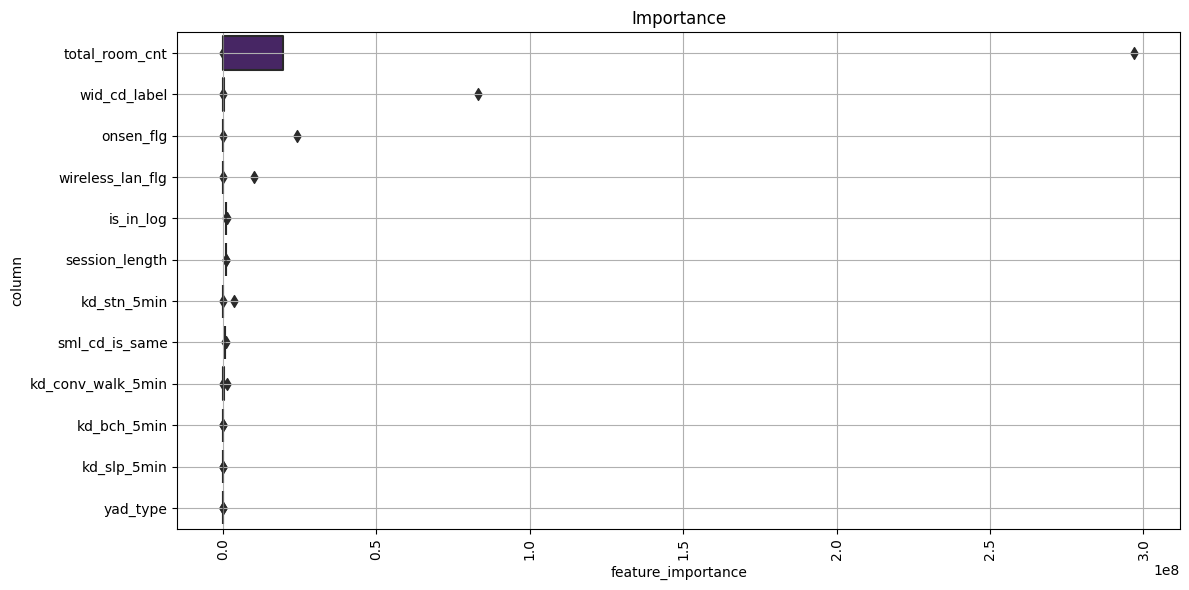

In [28]:
def visualize_importance(models, feat_train_df):
    """
    LightGBMのmodel配列のfeature_importanceをplotする
    CVごとのブレをboxen plot
    
    Args:
        models:
        feat_train_df:
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i+1
        
        feature_importance_df = pd.concat(
            [feature_importance_df, _df],
            axis=0,
            ignore_index=True,
        )
        
    order = feature_importance_df.groupby("column").sum()[["feature_importance"]].sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

## Infer

In [29]:
# k個のモデルの予測確率を生成 shape=(5, N_test)
pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])

pred_prob = np.mean(pred_prob, axis=0)

In [30]:
pred_prob

array([0.0005212 , 0.00057705, 0.00066943, ..., 0.00261421, 0.00336009,
       0.00337109])

### 予測値の確認

out of foldの予測確率の分布とtestへの予測確率の分布を見る

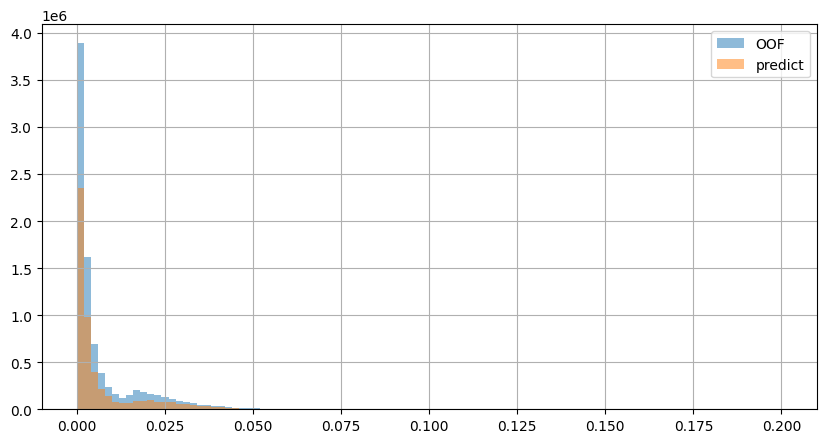

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, 0.2, 101)

ax.hist(oof, bins=bins, alpha=.5, label="OOF")
ax.hist(pred_prob, bins=bins, alpha=.5, label="predict")

ax.legend()
ax.grid()

In [32]:
submission = predict_top10_yad(predict=pred_prob, _df=test_df)
submission.columns = [f"predict_{c}" for c in submission.columns]
submission = submission.reset_index(drop=True)

In [33]:
submission.to_csv("submission.csv", index=False)